# Convert raw wind data into daily averages with direction

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import math

In [12]:
def getDateList(startDate, endDate, delta=1):
    # Get a list of dates between 2 dates (inclusive)
    dateList = []
    currentDate = startDate
    while currentDate <= endDate:
        dateList.append(currentDate)
        currentDate += timedelta(days=delta)
    return dateList

def calculateSpeedMean(vals):
    valSum = 0
    for val in list(vals):
        valSum += abs(val)
    return valSum/len(vals)

def calculateAngleMean(vals):
    return sum(vals)/len(vals)

def pythag(a, b):
    return (a**2+b**2)**0.5

def calculateWindAngle(u, v):
    # Calculates the angle (deg) the wind is GOING using U and V components
    if (u>0 and v>0):
        return math.atan(u/v) * (180/math.pi)
    elif (u>0 and v<0):
        return 90 + math.atan(abs(v)/u) * (180/math.pi) 
    elif (u<0 and v<0):
        return 180 + math.atan(abs(u)/abs(v)) * (180/math.pi)
    elif (u<0 and v>0):
        return 270 + math.atan(v/abs(u)) * (180/math.pi)

    # Zero Cases
    if(u==0 and v==0):
        return 0
    elif(u==0 and not v==0):
        if v>0:
            return 0
        else:
            return 180
    elif(not u==0 and v==0):
        if u>0:
            return 90
        else:
            return 270


In [17]:
dataFilePath = "./data/wind/raw/megaDB.csv"
startDate = "01/01/2016:00:00:00" # The starting date (note that it assume the dataset begins at midnight)
temporalResolution = 1 # Number of hours between each value

startDate = datetime.strptime(startDate, "%d/%m/%Y:%H:%M:%S")

# Output Variables
labels = ["date", "windspeed (ms^-1)", "u-component(ms^-1)", "v-component(ms^-1)", "angle(0deg=North)", "rough-direction"]
directionLabels = {0:"S", 45: "SW", 90: "W", 135: "NW", 180: "N", 225: "NE", 270: "E", 315: "SE"}

In [18]:
# Load .csv and remove first row
importArray = np.genfromtxt(dataFilePath, delimiter=",")
windData = importArray[1:]

In [19]:
# Assign each datapoint an epoch time
startTime = startDate.timestamp()
endTime = 0
for rowIndex, row in enumerate(windData):
    windData[rowIndex][0] = startTime + rowIndex * 3600
    endTime = startTime + rowIndex * 3600
endDate = datetime.fromtimestamp(endTime)

In [20]:
# Create a dictionary to hold the u and v-vlaues
dateList = getDateList(startDate, endDate)
outputArray = np.empty((len(dateList), len(labels)-2))
meanValues = {}

for date in dateList:
    meanValues[date.strftime("%d/%m/%Y")] = {"u-values": [], "v-values": []}
    
# Sort each row into the correct date
for row in windData:
    rowDate = datetime.fromtimestamp(row[0])
    meanValues[rowDate.strftime("%d/%m/%Y")]["u-values"].append(row[1])
    meanValues[rowDate.strftime("%d/%m/%Y")]["v-values"].append(row[2])

In [21]:
directionList = []
speeds = []
for dateIndex, date in enumerate(dateList):
    absUValue = calculateSpeedMean(meanValues[date.strftime("%d/%m/%Y")]["u-values"])
    absUValue = calculateSpeedMean(meanValues[date.strftime("%d/%m/%Y")]["v-values"])
    uValue = calculateAngleMean(meanValues[date.strftime("%d/%m/%Y")]["u-values"])
    vValue = calculateAngleMean(meanValues[date.strftime("%d/%m/%Y")]["v-values"])
    angle = calculateWindAngle(uValue, vValue)
    outputArray[dateIndex][0] = pythag(absUValue, absUValue)
    outputArray[dateIndex][1] = uValue
    outputArray[dateIndex][2] = vValue
    outputArray[dateIndex][3] = angle
    
    speeds.append(outputArray[dateIndex][0])
    
    directionLabelAngles = list(directionLabels.keys())
    for index, directionAngle in enumerate(directionLabelAngles):
        try:
            if angle >= directionAngle and angle < directionLabelAngles[index+1]:
                directionList.append(directionLabels[directionAngle])
        except IndexError:
            directionList.append("SE")

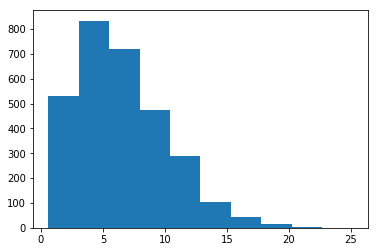

In [22]:
plt.hist(speeds)
plt.show()

In [23]:
with open("data\wind\processed\megaDB.csv", "w", encoding="utf-8") as outputFile:
    outputFile.write(",".join(labels)+"\n")
    for rowIndex, row in enumerate(outputArray):
        outputFile.write(f"{dateList[rowIndex].strftime('%d/%m/%Y')},{','.join([str(val) for val in row.tolist()])},{directionList[rowIndex]}\n")